## Autoencoder

[참조]
  - https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694
  - https://blog.keras.io/building-autoencoders-in-keras.html
  - http://solarisailab.com/archives/113

<br/>

### Autoencoder(AE)란

<img src="./image/Autoencoders__Introduction.png " width="400">

<br/>
- data compression algorithm으로 compression과 decompression으로 이루어진 함수(특히 Neural Network에서)를 의미 함
- 보통 Input :Ouput 구조가 data : probabiliy distributionof the clasees인 일반적인 모형(Classifiers)와는 다르게 AE는 Input : output 구조가 동일 ()
   [Noise 제거 목적으로 Input에 Noise 값을 추가하는 경우도 있음]
   <br/>
   <img src="./image/input_w_noise.png " width="400">
   
 <br/>
 
- AE는 다음과 같은 3가지의 특징을 가짐
   - data-specific : AE 모델이 학습 시 사용한 Data와 유사한 Data에 대해서만 차원축소(compression)이 가능
   - lossy : original Input 데이터 차원축소 시 데이터 손실이 발생
   - leared automatically : 분석가가 Output(target)을 정의할 필요없이 데이터만으로 학습 가능
   <br/>
   
- AE 활용처
   - 2012년 초기에는 Deep Convolutional Network의 pre-train에 사용하였음. 그러나 random weight initialization, batch normalization, residual learing 방법이 더 효과적인 것으로 판명되며 pre-train에는 거의 사용되지 않음
   - 현재는 주로 2가지 영역에 많이 사용되고 있음
      - 1) Data Denoising
      - 2) Dimensionality Reduction for data visualization
        - t-SNE의 경우 low-dimension일 때 적합하기에, AE를 이용하여 차원 축소 후 t-SNE를 적용할 수 있음

## Gluon을 이용한 Autoencoder 예제

In [30]:
# Gluon module load
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
ctx = mx.cpu()

### Load MNIST Data Set
 - Gluon Data API를 이용하지 않고 MNIST ubyte data set을 직접 load
   - 동일한 Data Set을 기준으로 Keras 기반 모델과의 Code 및 Performance 비교 목적

In [31]:
# ubytes load function

import os, struct
import numpy as np

def load_mnist(train = True, fashion = False, path = './'):
    if train == True:
        if fashion == True:
            img_fname = str(path + 'fashion/train-images-idx3-ubyte')
            lbl_fname = str(path + 'fashion/train-labels-idx1-ubyte')
        else:
            img_fname = str(path + 'mnist/train-images-idx3-ubyte')
            lbl_fname = str(path + 'mnist/train-labels-idx1-ubyte')
    else:        
        if fashion == True:
            img_fname = str(path + 'fashion/t10k-images-idx3-ubyte')
            lbl_fname = str(path + 'fashion/t10k-labels-idx1-ubyte')        
        else:
            img_fname = str(path + 'mnist/t10k-images-idx3-ubyte')
            lbl_fname = str(path + 'mnist/t10k-labels-idx1-ubyte')   
    
    
    with open(lbl_fname, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(img_fname, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    img_f = []
    lbl_f = []
    
    for i in range(len(lbl)):
        img_f.append(img[i])
        lbl_f.append(lbl[i])
    
    return img, lbl

##############
# Keras API를 이용할 경우

# Keras API를 이용한 MNIST Dataset Load
# from keras.datasets import mnist
# import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print(x_train.shape)
# print(x_test.shape)

In [32]:
## Auto encoder 결과값 확인을 위한 function (원 데이터 <-> 예측데이터 plotting)
def plot_result(img_set_1, img_set_2, num = 10, fig_size = (20,4)):
    import matplotlib.pyplot as plt
    import math

    img_1_dim = int(math.sqrt(img_set_1.shape[1]))
    img_2_dim = int(math.sqrt(img_set_2.shape[1]))
    
    # num = how many digits we will display
    plt.figure(figsize = fig_size)
    for i in range(num):
        # display original
        ax = plt.subplot(2, num, i + 1)
        plt.imshow(img_set_1[i].reshape(img_1_dim, img_1_dim))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, num, i + 1 + num)
        plt.imshow(img_set_2[i].reshape(img_2_dim, img_2_dim))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [33]:
# 10 digits mnist data set
train_i, train_l = load_mnist(train = True, fashion = False, path = './')
test_i, test_l = load_mnist(train = False, fashion = False, path = './')
print(train_i.shape)
print(test_i.shape)

(60000, 28, 28)
(10000, 28, 28)


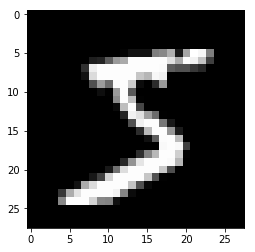

In [34]:
import matplotlib.pyplot as plt
plt.imshow(train_i[0].reshape(28, 28, 1).reshape(28,28))
plt.gray()
plt.show()

In [35]:
# 10 category fashion mnist data set
f_train_i, f_train_l = load_mnist(train = True, fashion = True, path = './')
f_test_i, f_test_l = load_mnist(train = False, fashion = True, path = './')

print(f_train_i.shape)
print(f_test_i.shape)

(60000, 28, 28)
(10000, 28, 28)


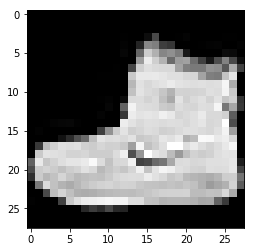

In [36]:
import matplotlib.pyplot as plt
plt.imshow(f_train_i[0].reshape(28, 28, 1).reshape(28,28))
plt.gray()
plt.show()

## Data preprocessing

In [37]:
# data normalization [0,1] CNN용
train_cnn = train_i.reshape(train_i.shape[0], train_i.shape[1], train_i.shape[1], 1).astype('float32') / 255.
train_cnn = train_cnn.transpose((0,3,1,2))
test_cnn = test_i.reshape(test_i.shape[0], test_i.shape[1], test_i.shape[1], 1).astype('float32') / 255.
test_cnn = test_cnn.transpose((0,3,1,2))
print(train_cnn.shape)

# data normalization [0,1] & flattening
train_i = train_i.reshape(train_i.shape[0], train_i.shape[1]*train_i.shape[1]).astype('float32') / 255.
test_i = test_i.reshape(test_i.shape[0], test_i.shape[1]*test_i.shape[1]).astype('float32') / 255.
print(train_i.shape)

# noise factor 추가
noise_factor = 0.3
train_i_n = train_i + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_i.shape) 
test_i_n = test_i + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_i.shape) 
train_i_n = np.clip(train_i_n, 0., 1.) # [0,1 사이로 clipping]
test_i_n = np.clip(test_i_n, 0., 1.)

train_cnn_n = train_cnn + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_cnn.shape) 
test_cnn_n = test_cnn + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_cnn.shape) 
train_cnn_n = np.clip(train_cnn_n, 0., 1.) # [0,1 사이로 clipping]
test_cnn_n = np.clip(test_cnn_n, 0., 1.)

(60000, 1, 28, 28)
(60000, 784)


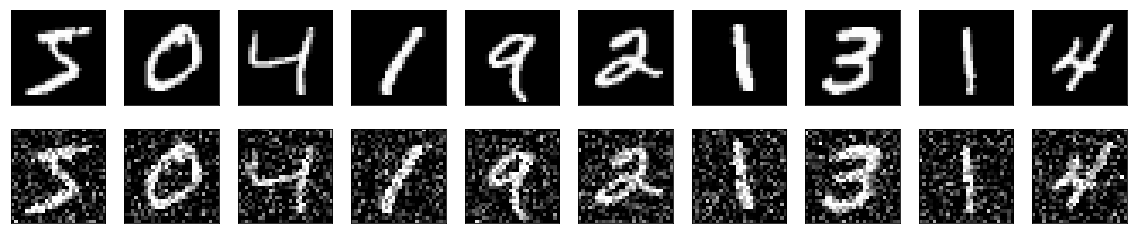

In [38]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(train_i[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(train_i_n[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
# convert numpy array to nd array (gluon에서 사용하기 위해)
x_train_nd_cnn = nd.array(train_cnn)
x_test_nd_cnn = nd.array(test_cnn)

x_train_nd_cnn_n = nd.array(train_cnn_n)
x_test_nd_cnn_n = nd.array(test_cnn_n)

x_train_nd = nd.array(train_i)
x_test_nd = nd.array(test_i)

x_train_nd_n = nd.array(train_i_n)
x_test_nd_n = nd.array(test_i_n)

# make data_loader (mini-batch를 쉽게 만들기 위해 gluon DataLoader API 활용)
batch_size = 256
x_train_lodaer_cnn = gluon.data.DataLoader(x_train_nd_cnn, batch_size = batch_size, shuffle=True)
x_test_lodaer_cnn = gluon.data.DataLoader(x_train_nd_cnn, batch_size = batch_size, shuffle=True)

x_train_lodaer_cnn_n = gluon.data.DataLoader(x_train_nd_cnn_n, batch_size = batch_size, shuffle=True)
x_test_lodaer_cnn_n = gluon.data.DataLoader(x_train_nd_cnn_n, batch_size = batch_size, shuffle=True)

x_train_lodaer = gluon.data.DataLoader(x_train_nd, batch_size = batch_size, shuffle=True)
x_test_lodaer = gluon.data.DataLoader(x_train_nd, batch_size = batch_size, shuffle=True)

x_train_lodaer_n = gluon.data.DataLoader(x_train_nd_n, batch_size = batch_size, shuffle=True)
x_test_lodaer_n = gluon.data.DataLoader(x_train_nd_n, batch_size = batch_size, shuffle=True)

### Autoencoder Network

### 1. Simple AE

In [40]:
class autoencoder_simple(gluon.Block):
    def __init__(self):
        super(autoencoder_simple, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Dense(16, activation='relu')) # encoding & latent layer
                
            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(28 * 28, activation='sigmoid'))
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
learning_rate = 1e-3

model_1 = autoencoder_simple()
model_1.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model_1.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [42]:
model_1.collect_params

<bound method Block.collect_params of autoencoder_simple(
  (decoder): Sequential(
    (0): Dense(None -> 784, Activation(sigmoid))
  )
  (encoder): Sequential(
    (0): Dense(None -> 16, Activation(relu))
  )
)>

In [43]:
num_epochs = 20
data_loader = x_train_lodaer
model = model_1

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    
    for data in data_loader:
        img = data
        img = img.as_in_context(ctx)
#         img = img.reshape((img.shape[0], -1)).as_in_context(ctx)

        with mx.autograd.record():
            output = model(img)
            loss = criterion(output, img) # autoencoder의 target 값
        loss.backward()
        optimizer.step(img.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += img.shape[0]
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))

epoch [1/20], loss:0.0403
epoch [2/20], loss:0.0222
epoch [3/20], loss:0.0180
epoch [4/20], loss:0.0159
epoch [5/20], loss:0.0147
epoch [6/20], loss:0.0139
epoch [7/20], loss:0.0135
epoch [8/20], loss:0.0132
epoch [9/20], loss:0.0130
epoch [10/20], loss:0.0128
epoch [11/20], loss:0.0126
epoch [12/20], loss:0.0123
epoch [13/20], loss:0.0121
epoch [14/20], loss:0.0119
epoch [15/20], loss:0.0118
epoch [16/20], loss:0.0117
epoch [17/20], loss:0.0116
epoch [18/20], loss:0.0115
epoch [19/20], loss:0.0115
epoch [20/20], loss:0.0114


In [44]:
# encoding된 값
encoded_imgs = model.encoder(x_test_nd).asnumpy()
print(encoded_imgs.shape)

# decoding된 값 
decoded_imgs = model(x_test_nd).asnumpy()
print(decoded_imgs.shape)

(10000, 16)
(10000, 784)


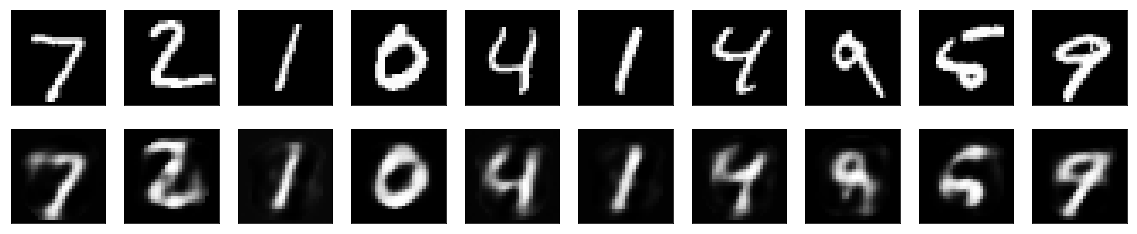

In [45]:
# test raw data vs decoded data
plot_result(test_i, decoded_imgs)

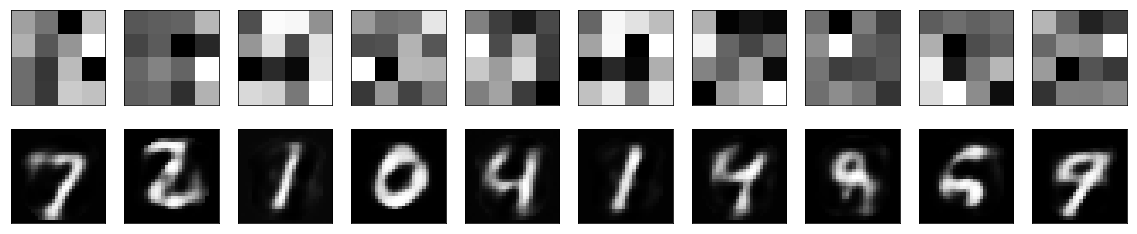

In [46]:
# encoded data vs decoded data
plot_result(encoded_imgs, decoded_imgs)

In [47]:
# denosied images encoding된 값
encoded_imgs_2 = model.encoder(x_test_nd_n).asnumpy()
print(encoded_imgs.shape)

# denosied images decoding된 값 
decoded_imgs_2 = model(x_test_nd_n).asnumpy()
print(decoded_imgs.shape)

(10000, 16)
(10000, 784)


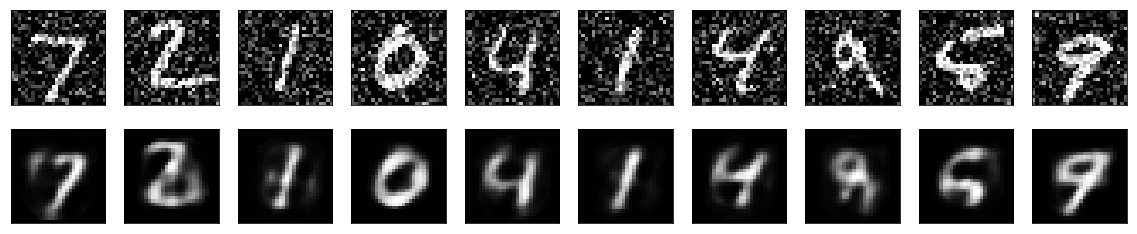

In [48]:
plot_result(test_i_n, decoded_imgs_2)

### 2. Deep AE

In [49]:
class autoencoder_deep(gluon.Block):
    def __init__(self):
        super(autoencoder_deep, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Dense(128, activation='relu'))
                self.encoder.add(gluon.nn.Dense(64, activation='relu'))
                self.encoder.add(gluon.nn.Dense(32, activation='relu'))
                self.encoder.add(gluon.nn.Dense(16)) # latent layer
                
            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(32, activation='relu'))
                self.decoder.add(gluon.nn.Dense(64, activation='relu'))
                self.decoder.add(gluon.nn.Dense(128, activation='relu'))
                self.decoder.add(gluon.nn.Dense(28 * 28, activation='sigmoid'))
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
learning_rate = 1e-3

model_2 = autoencoder_deep()
model_2.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model_2.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [51]:
model_2.collect_params

<bound method Block.collect_params of autoencoder_deep(
  (decoder): Sequential(
    (0): Dense(None -> 32, Activation(relu))
    (1): Dense(None -> 64, Activation(relu))
    (2): Dense(None -> 128, Activation(relu))
    (3): Dense(None -> 784, Activation(sigmoid))
  )
  (encoder): Sequential(
    (0): Dense(None -> 128, Activation(relu))
    (1): Dense(None -> 64, Activation(relu))
    (2): Dense(None -> 32, Activation(relu))
    (3): Dense(None -> 16, linear)
  )
)>

In [52]:
num_epochs = 20
data_loader = x_train_lodaer
model = model_2

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    
    for data in data_loader:
        img = data
        img = img.as_in_context(ctx)
#         img = img.reshape((img.shape[0], -1)).as_in_context(ctx)

        with mx.autograd.record():
            output = model(img)
            loss = criterion(output, img) # autoencoder의 target 값
        loss.backward()
        optimizer.step(img.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += img.shape[0]
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))

epoch [1/20], loss:0.0344
epoch [2/20], loss:0.0192
epoch [3/20], loss:0.0163
epoch [4/20], loss:0.0147
epoch [5/20], loss:0.0137
epoch [6/20], loss:0.0131
epoch [7/20], loss:0.0127
epoch [8/20], loss:0.0124
epoch [9/20], loss:0.0121
epoch [10/20], loss:0.0119
epoch [11/20], loss:0.0117
epoch [12/20], loss:0.0115
epoch [13/20], loss:0.0114
epoch [14/20], loss:0.0111
epoch [15/20], loss:0.0109
epoch [16/20], loss:0.0107
epoch [17/20], loss:0.0106
epoch [18/20], loss:0.0105
epoch [19/20], loss:0.0104
epoch [20/20], loss:0.0103


In [53]:
# encoding된 값
encoded_imgs = model.encoder(x_test_nd).asnumpy()
print(encoded_imgs.shape)

# decoding된 값 
decoded_imgs = model(x_test_nd).asnumpy()
print(decoded_imgs.shape)

(10000, 16)
(10000, 784)


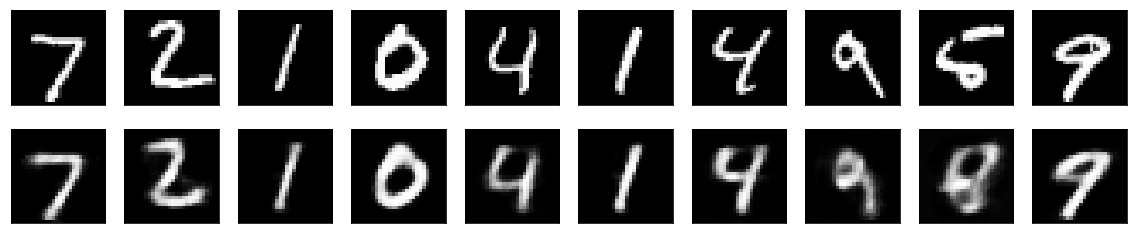

In [54]:
# test raw data vs decoded data
plot_result(test_i, decoded_imgs)

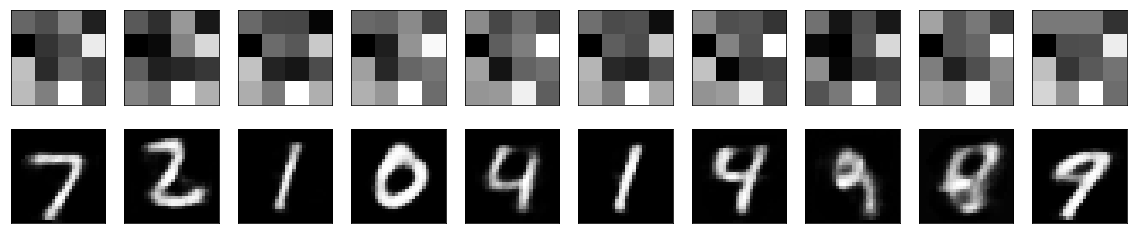

In [55]:
# encoded data vs decoded data
plot_result(encoded_imgs, decoded_imgs)

In [56]:
# denosied images encoding된 값
encoded_imgs_2 = model.encoder(x_test_nd_n).asnumpy()
print(encoded_imgs.shape)

# denosied images decoding된 값 
decoded_imgs_2 = model(x_test_nd_n).asnumpy()
print(decoded_imgs.shape)

(10000, 16)
(10000, 784)


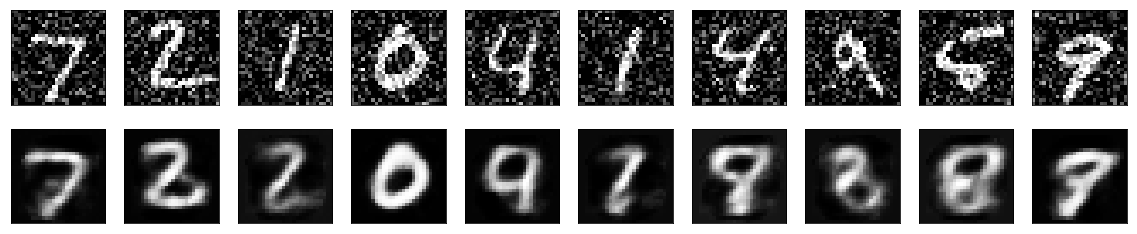

In [57]:
plot_result(test_i_n, decoded_imgs_2)

### 3. CNN AE

In [58]:
class autoencoder_cnn(gluon.Block):
    def __init__(self):
        super(autoencoder_cnn, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
                # b, 16, 10, 10
                self.encoder.add(
                    gluon.nn.Conv2D(
                        16, 3, strides=3, padding=1, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2, 2))  # b, 16, 5, 5
                self.encoder.add(
                    gluon.nn.Conv2D(8, 3, strides=2, padding=1,
                                activation='relu'))  # b, 8, 3, 3
                self.encoder.add(gluon.nn.MaxPool2D(2, 1))  # b, 8, 2, 2

            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(
                    gluon.nn.Conv2DTranspose(16, 3, strides=2, activation='relu'))
                self.decoder.add(
                    gluon.nn.Conv2DTranspose(
                        8, 5, strides=3, padding=1, activation='relu'))
                self.decoder.add(
                    gluon.nn.Conv2DTranspose(
                        1, 2, strides=2, padding=1, activation='tanh'))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [59]:
learning_rate = 1e-3

model_3 = autoencoder_cnn()
model_3.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model_3.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [60]:
num_epochs = 20
data_loader = x_train_lodaer_cnn
model = model_3

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    
    for data in data_loader:
        img = data.as_in_context(ctx)
        batch = img.shape[0]

        with mx.autograd.record():
            output = model(img)
            loss = criterion(output, img) # autoencoder의 target 값
        loss.backward()
        optimizer.step(img.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += img.shape[0]
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))

epoch [1/20], loss:0.0341
epoch [2/20], loss:0.0221
epoch [3/20], loss:0.0195
epoch [4/20], loss:0.0184
epoch [5/20], loss:0.0176
epoch [6/20], loss:0.0171
epoch [7/20], loss:0.0166
epoch [8/20], loss:0.0162
epoch [9/20], loss:0.0159
epoch [10/20], loss:0.0156
epoch [11/20], loss:0.0153
epoch [12/20], loss:0.0151
epoch [13/20], loss:0.0148
epoch [14/20], loss:0.0146
epoch [15/20], loss:0.0144
epoch [16/20], loss:0.0143
epoch [17/20], loss:0.0141
epoch [18/20], loss:0.0140
epoch [19/20], loss:0.0139
epoch [20/20], loss:0.0138


In [61]:
list(x_test_nd)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [62]:
# encoding된 값
encoded_imgs = model.encoder(x_test_nd_cnn).asnumpy()
print(encoded_imgs.shape)

# decoding된 값 
decoded_imgs = model(x_test_nd_cnn).asnumpy()
print(decoded_imgs.shape)

(10000, 8, 2, 2)
(10000, 1, 28, 28)


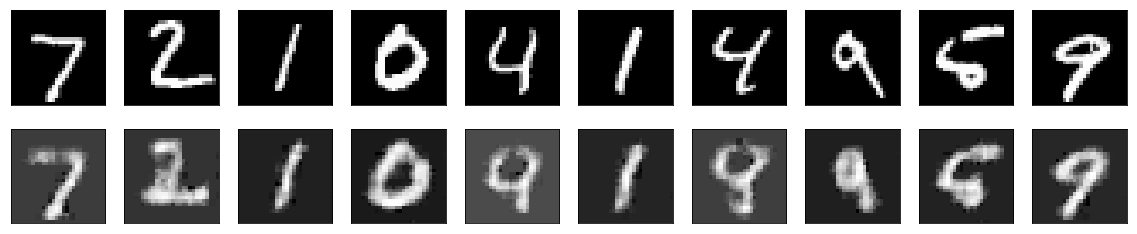

In [63]:
# test raw data vs decoded data
plot_result(test_i, decoded_imgs.reshape(10000,784))

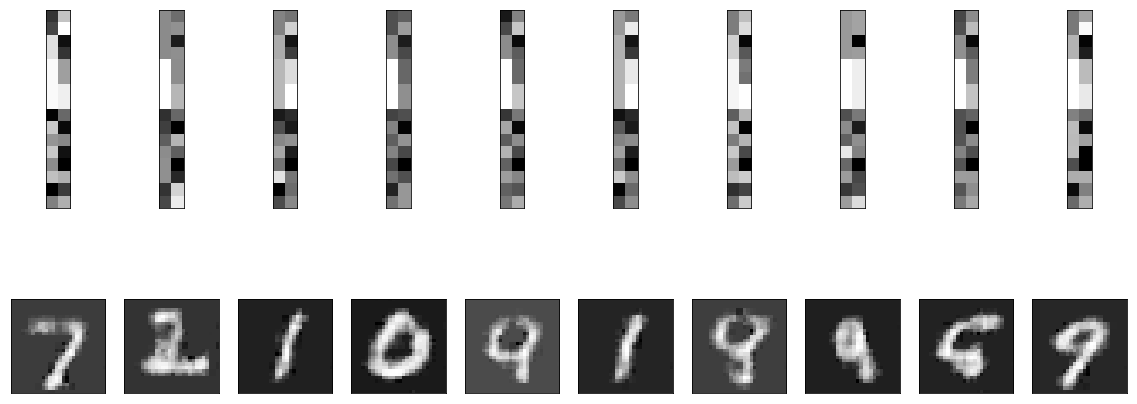

In [64]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, n, i +1)
    plt.imshow(encoded_imgs[i].reshape(2, 4 * 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(decoded_imgs[i].shape[1], decoded_imgs[i].shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [65]:
# encoding된 값
encoded_imgs_2 = model.encoder(x_test_nd_cnn_n).asnumpy()
print(encoded_imgs.shape)

# decoding된 값 
encoded_imgs_2 = model(x_test_nd_cnn_n).asnumpy()
print(decoded_imgs.shape)

(10000, 8, 2, 2)
(10000, 1, 28, 28)


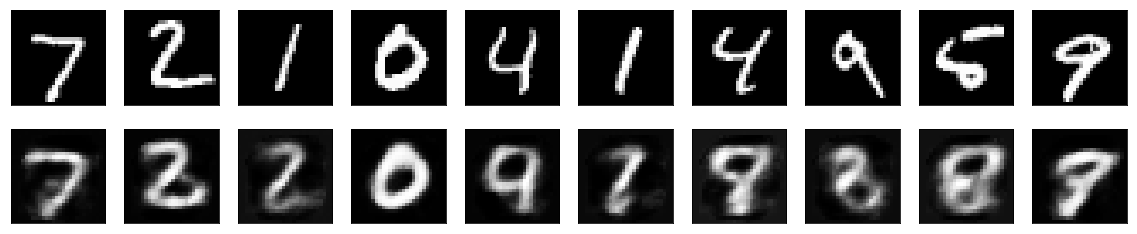

In [66]:
# test raw data vs decoded data
plot_result(test_i, decoded_imgs_2.reshape(10000,784))